[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanharvey1/neuro_py/blob/main/tutorials/reactivation.ipynb)
&nbsp;
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ryanharvey1/neuro_py/main/tutorials/reactivation.ipynb)
&nbsp;
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanharvey1/neuro_py/main?labpath=tutorials%2Freactivation.ipynb)

# Reactivation 

Here, we will show how to use the [`AssemblyReact`](https://ryanharvey1.github.io/neuro_py/reference/neuro_py/ensemble/assembly_reactivation/#neuro_py.ensemble.assembly_reactivation.AssemblyReact)
class to identify assemblies and assess reactivation during post-task sleep

---

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

# from neuro_py
from neuro_py.ensemble.assembly_reactivation import AssemblyReact
from neuro_py.process.peri_event import event_triggered_average_fast
from neuro_py.io import loading

# core tools
import nelpy as nel
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Section 1: Pick basepath and initialize AssemblyReact class

Here we will use CA1 pyramidal cells.

In [2]:
basepath = r"Z:\Data\HMC1\day8"

assembly_react = AssemblyReact(
    basepath=basepath,
    brainRegion="CA1",
    putativeCellType="Pyr",
    z_mat_dt=0.01,
)

Also, load brain states for later use.

In [3]:
# load theta epochs
state_dict = loading.load_SleepState_states(basepath)
theta_epochs = nel.EpochArray(
    state_dict["THETA"],
)
nrem_epochs = nel.EpochArray(
    state_dict["NREMstate"],
)
theta_epochs, nrem_epochs

(<EpochArray at 0x22d5cbc65e0: 125 epochs> of length 35:04 minutes,
 <EpochArray at 0x22d7f5ac730: 88 epochs> of length 2:16:25 hours)

## Section 2: Load spike data, session epochs, and ripple events

You can see there there are nice printouts that display important information about the class

In [4]:
# load need data (spikes, ripples, epochs)
assembly_react.load_data()
assembly_react

<AssemblyReact: 75 units> of length 6:36:57:689 hours

Locate the session from which you want to detect assemblies.

Here we can see a *novel* `linear` track is the second epoch.

In [5]:
assembly_react.epoch_df

,name,startTime,stopTime,environment,behavioralParadigm,notes,basepath
0,preSleep_210411_064951,0.0,9544.56315,sleep,NaN,NaN,Z:\Data\HMC1\day8
1,maze_210411_095201,9544.5632,11752.80635,linear,1,novel,Z:\Data\HMC1\day8
2,postSleep_210411_103522,11752.8064,23817.68955,sleep,NaN,NaN,Z:\Data\HMC1\day8


## Section 3: Detect assembles in linear track during theta

You can see we have detected 15 assemblies

In [6]:
assembly_react.get_weights(epoch=assembly_react.epochs[1] & theta_epochs)
assembly_react

<AssemblyReact: 75 units, 15 assemblies> of length 6:36:57:689 hours

## Section 4: Analyze the obtained assemblies

### Section 4.1: Visualize assembly weights

Each column is a assembly and each row is a cell

The color indicates if the cell was a significant contributor (members) to that assembly
* you can find these members with assembly_members = assembly_react.find_members()

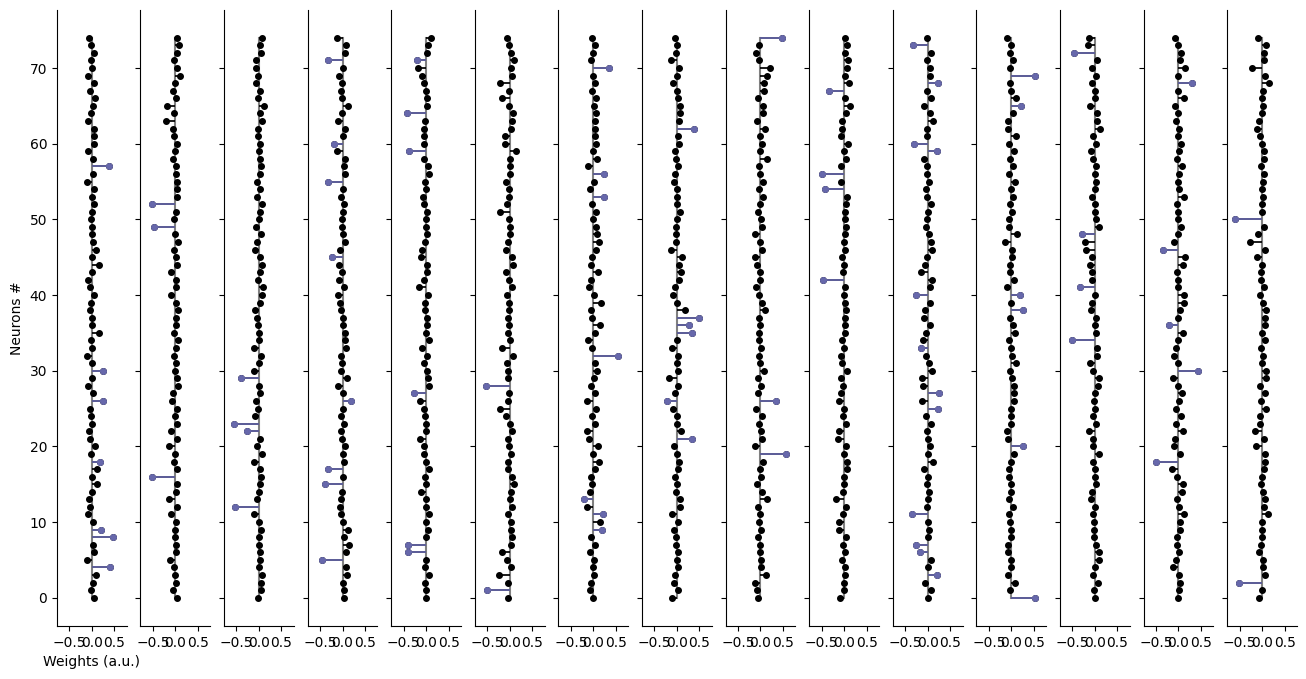

In [7]:
assembly_react.plot()
plt.show()

### Section 4.2: Compute time-resolved activations for each assembly

Will take around a minute to run.

In [8]:
assembly_act = assembly_react.get_assembly_act()
assembly_act

<AnalogSignalArray at 0x22d56d63670: 15 signals> for a total of 6:36:57:680 hours

### Section 4.3: Get assembly strengths around ripples in pre-sleep, the task, and in post-sleep epochs

In [9]:
nrem_ripples = assembly_react.ripples & nrem_epochs

psth_swr_pre = event_triggered_average_fast(
    assembly_act.data,
    nrem_ripples[assembly_react.epochs[0]].starts,
    sampling_rate=assembly_act.fs,
    window=[-0.5, 0.5],
    return_average=True,
    return_pandas=True,
)
psth_swr_task = event_triggered_average_fast(
    assembly_act.data,
    assembly_react.ripples[assembly_react.epochs[1]].starts,
    sampling_rate=assembly_act.fs,
    window=[-0.5, 0.5],
    return_average=True,
    return_pandas=True,
)
psth_swr_post = event_triggered_average_fast(
    assembly_act.data,
    nrem_ripples[assembly_react.epochs[2]].starts,
    sampling_rate=assembly_act.fs,
    window=[-0.5, 0.5],
    return_average=True,
    return_pandas=True,
)

# round time index to 3 decimals for plotting
psth_swr_pre.index = np.round(psth_swr_pre.index, 3)
psth_swr_task.index = np.round(psth_swr_task.index, 3)
psth_swr_post.index = np.round(psth_swr_post.index, 3)

### Section 4.4: Visualize reactivation dynamics during post-task ripples

Here, we have plotted *Pre*, *Post*, and *Post* subtracted by *Pre* to estimate the difference.

You can see that many of the assembles have a higher reactivation during the post-task ripples compared to the pre-task ripples.

C:\Users\Cornell\AppData\Local\Temp\ipykernel_27712\1971619650.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
C:\Users\Cornell\AppData\Local\Temp\ipykernel_27712\1971619650.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


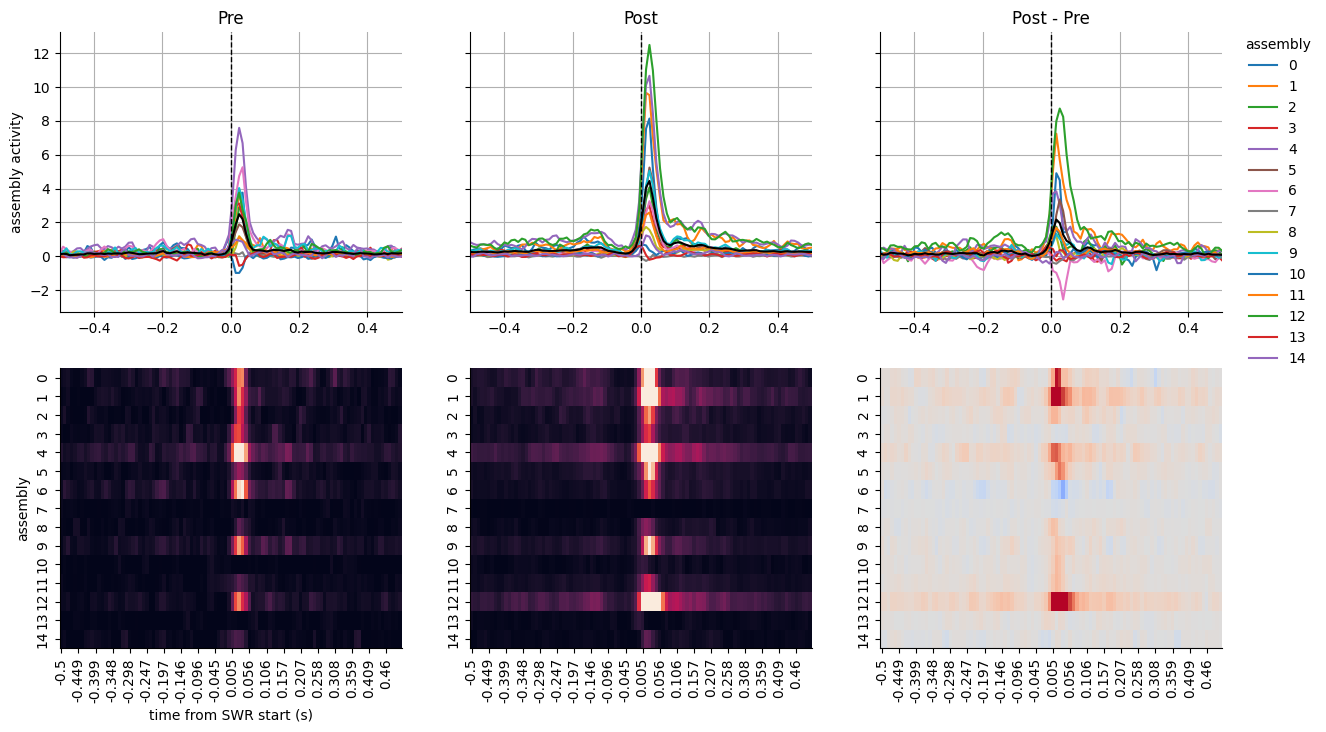

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharey=False, sharex=False)
ax = ax.flatten()

# share y axis of first row
ax[0] = plt.subplot(231, sharey=ax[1])
ax[2] = plt.subplot(233, sharey=ax[0])

# plot assembly ripple psth
psth_swr_pre.plot(ax=ax[0], legend=False)
psth_swr_post.plot(ax=ax[1], legend=False)
(psth_swr_post - psth_swr_pre).plot(ax=ax[2])

# plot mean assembly ripple psth
psth_swr_pre.mean(axis=1).plot(ax=ax[0], color="k", legend=False)
psth_swr_post.mean(axis=1).plot(ax=ax[1], color="k", legend=False)
(psth_swr_post - psth_swr_pre).mean(axis=1).plot(ax=ax[2], color="k")

# plot assembly ripple psth heatmap
sns.heatmap(psth_swr_pre.T, ax=ax[3], cbar=False, vmin=0, vmax=5)
sns.heatmap(psth_swr_post.T, ax=ax[4], cbar=False, vmin=0, vmax=5)
sns.heatmap(
    (psth_swr_post - psth_swr_pre).T,
    ax=ax[5],
    cbar=False,
    vmin=-5,
    vmax=5,
    cmap="coolwarm",
)

for ax_ in ax[:3]:
    # dashed line at zero
    ax_.axvline(0, linestyle="--", color="k", linewidth=1)
    # set x axis limits
    ax_.set_xlim(-0.5, 0.5)
    # add grid lines
    ax_.grid()

ax[0].set_title("Pre")
ax[1].set_title("Post")
ax[2].set_title("Post - Pre")

# move legend
ax[2].legend(
    bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, frameon=False, title="assembly"
)

# add labels
ax[0].set_ylabel("assembly activity")
ax[3].set_ylabel("assembly")
ax[3].set_xlabel("time from SWR start (s)")

# clean axis using seaborn
sns.despine()

plt.show()

---